# Optimization of a circulator layout

Author: Alexis Morvan
Date: 2021-08-24

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# silencing pyomo wanring
import logging
import itertools

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# import pandas as pd

## Definition of the layout
We are defining a circular layout of N-transmons. Here we consider a simple circular layout where the edge goes likes:

0 --> 1 --> 2 --> ... --> N//2 <-- ... <-- N-1 <-- N <-- 0

In [2]:
architecture = "CR"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = True # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

#thresholds
if architecture == 'CR':
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

elif (architecture == 'CR') and qutrit:
    d_dict = {'A1': 0.017,
              'A2i': 0.03,
              'A2j': 0.03,
              'A3i': 0.03,
              'A3j': 0.03,
              "E1": 0.017,
              "E2": 0.03,
              "E3": 0.03,
              "E4":0.002,
              "F1": 0.017,
              "F2":0.025,
              "F3": 0.025,
              "M1": 0.017}
    cr_keys = ['A1', 'A2i', 'A2j','A3i', 'A3j', "E1", "E2","E3", "E4",
               "C1", "C1b", "F1", "F2","F3",  "M1"]
    cstr_key = cr_keys
    
    
    
# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

# constructing the lattice
To construct the lattice, I am using the very neat features of pybinding package. In future, it might be worth having the pybinding code directly inside the codebase

In [3]:
import pybinding as pb


def hexagon_lattice_6():

    d = 1  # placeholder
    t = 1    # placeholder

    # create a simple 2D lattice with vectors a1 and a2
    lattice = pb.Lattice(a1=[6, 2], a2=[0, 4])
    
    nodes = [(f"A_{i}_{j}", [i, j]) for (i, j) in itertools.product(range(6),range(3))]
    for i in [1, 2, 3, 5]:
        nodes.remove((f"A_{i}_{1}", [i, 1]))
    nodes.append((f"A_{2}_{3}", [2, 3]))
    lattice.add_sublattices( *nodes)

    # add the hopping for the internal sub-lattice
    lattice.add_hoppings(((0, 0), "A_1_0", "A_0_0", t),
                         ((0, 0), "A_1_0", "A_2_0", t),
                         ((0, 0), "A_3_0", "A_2_0", t),
                         ((0, 0), "A_3_0", "A_4_0", t),
                         ((0, 0), "A_1_2", "A_0_2", t),
                         ((0, 0), "A_1_2", "A_2_2", t),
                         ((0, 0), "A_3_2", "A_2_2", t),
                         ((0, 0), "A_3_2", "A_4_2", t),
                         ((0, 0), "A_0_1", "A_0_0", t),
                         ((0, 0), "A_0_1", "A_0_2", t),
                         ((0, 0), "A_4_1", "A_4_0", t),
                         ((0, 0), "A_4_1", "A_4_2", t),
                         ((0, 0), "A_2_3", "A_2_2", t),
                         ((0, 0), "A_5_0", "A_4_0", t),
                         ((0, 0), "A_5_2", "A_4_2", t),
    )


#     # now the link between subregions
    lattice.add_hoppings(([0, 1], f'A_2_3', f'A_2_0', t),
                         ([1, -1], "A_5_0", "A_0_2", t),
                         ([1, 0], "A_5_2", "A_0_0", t),
#                          ([1, -1], "A_2_0", "A_0_1", t)
    )

    
    return lattice

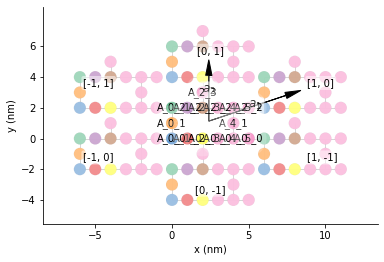

In [4]:
lattice = hexagon_lattice_6()
lattice.plot()  # plot the lattice that was just constructed
plt.show()      # standard matplotlib show() function

## Small model that we will solve

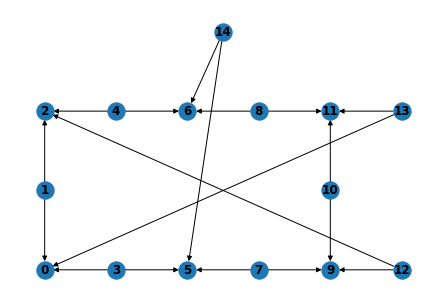

In [5]:
# n = 4

# lattice = square_lattice(n)
edges = [(y.from_id, y.to_id) for y in lattice.hoppings['__anonymous__0'].terms]
pos = {y.unique_id: y.position[:2] for y in lattice.sublattices.values()}  # only taking 2D
pos[14] = [2.5,3] 
# define the frequency graph
G = FrequencyGraph(edges=edges, cz=cz)

# plot if needed
G.plot(pos=pos)

In [6]:
pos[14]

[2.5, 3]

## Solving the small lattice

In [7]:
optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             all_differents=all_differents)

In [8]:
# perform the optimization
optimizer.declare_solver()
result = optimizer.first_pass()
print("first pass done")
result = optimizer.second_pass()
print("second pass done")
result = optimizer.third_pass()
print("third pass done")

first pass done
second pass done
third pass done


In [9]:
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)
print(G.check_solution(d_dict, cstr=cstr_key))

The drive frequency are CR compatible
True


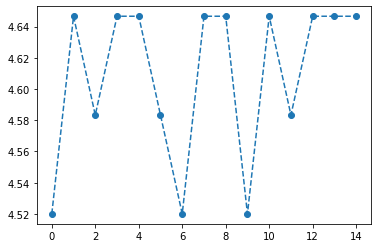

In [10]:
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')

In [11]:
G.freqs

array([4.52     , 4.6466665, 4.5833335, 4.6466665, 4.6466665, 4.5833335,
       4.52     , 4.6466665, 4.6466665, 4.52     , 4.6466665, 4.5833335,
       4.6466665, 4.6466665, 4.6466665], dtype=float32)

Qubit collisions:
yield   = 0.867226
average = 0.238294


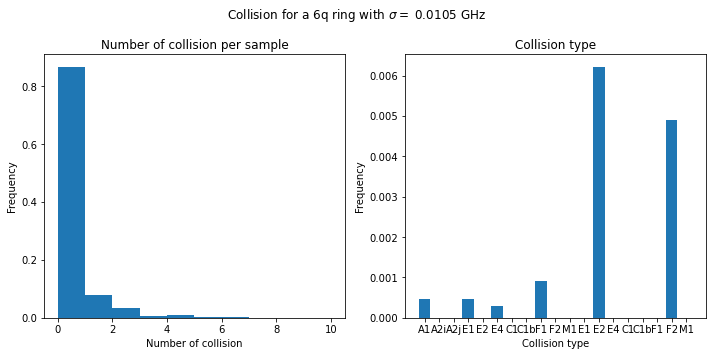

In [12]:
# parametrization
Nsamples = 1e6
sigma = 0.0105

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict, sigma=sigma, qutrit=qutrit, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(constraints)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

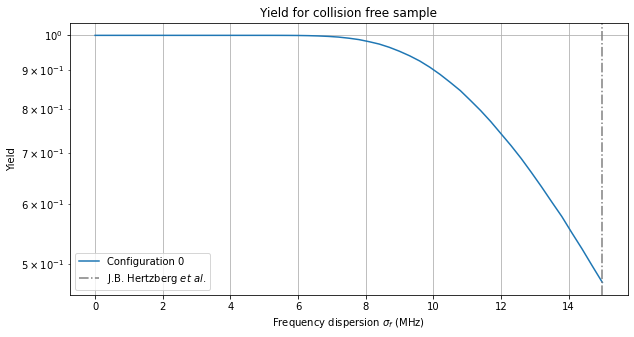

In [13]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 1e6

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.015, 21)

# saving the results
collisions = np.array([G.get_collision(d_dict, Nsamples=Nsamples, sigma=s, qutrit=qutrit, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

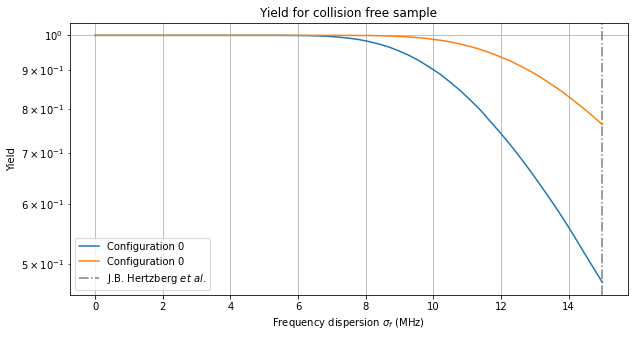

In [33]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')
ax.plot(s_vec*1e3, data, label=f'Configuration {0}')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

In [31]:
data = y[0]

## Tiling

1000


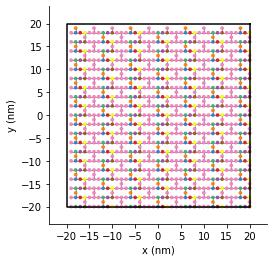

In [14]:
def rectangle(width, height):
    x0 = width / 2
    y0 = height / 2
    return pb.Polygon([[x0, y0], [x0, -y0], [-x0, -y0], [-x0, y0]])

shape = rectangle(width=40, height=40)

model = pb.Model(lattice, shape)
print(model.system.num_sites)

model.plot()
shape.plot()

In [15]:
def construct_tiling(G, model):

    freqs = {}
    anharms = {}
    drives = {}

    N = model.system.num_sites

    for node in range(N):

        # node values: frequencies and anharmonicity
        # # tge sublattice directly map to the node number of the Graph Frequency
        sublat = model.system.sublattices[node]
        freqs[node] = G.freqs[sublat]
        anharms[node] = G.anharmonicity[sublat]

        # now the edges:
        hop = model.system.hoppings.tocoo()
        edges = list(zip(hop.row, hop.col))

        for e in edges:
            e_sublat = tuple(model.system.sublattices[ee] for ee in e)
            drives[e] = G.drive[e_sublat]

    pos = {i: (model.system.x[i], model.system.y[i]) for i in range(N)}  # only taking 2D
    
    return freqs, anharms, edges, drives, pos

## Tiling of the large latice

In [16]:
freqs, anharms, edges, drives, pos = construct_tiling(G, model)

G2 = FrequencyGraph(edges=edges, cz=cz)
G2.set_values(freqs, anharms, drives)

The drive frequency are CR compatible


In [22]:
# saving the results
Nsamples= 1e4

collisions = np.array([G2.get_collision(d_dict, qutrit=qutrit, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-nn, axis=1))/Nsamples for nn in n_collisions]

No handles with labels found to put in legend.


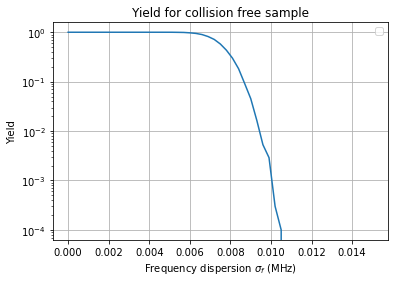

In [23]:
fig, ax = plt.subplots()
ax.plot(s_vec, y[0])

ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

In [27]:
data = y[0]
res= None
for i in range(len(s_vec)):
    if np.abs(data[i])>0.99:
        res = i
print(s_vec[int(res)]*1e3)

5.699999999999999


In [29]:
len(s_vec)

51